In [3]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scanpy as sc
from bbknn import bbknn
import scanorama as scanorama
import pandas as pd

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=100)

scanpy==1.6.0 anndata==0.7.4 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.7.0


In [4]:
P38_gaba = sc.read_h5ad('P38_dr_gaba.h5ad')

In [5]:
P38_gaba

AnnData object with n_obs × n_vars = 2512 × 20354
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample'
    var: 'gene_ids', 'feature_types', 'n_cells-P38_dr_1a', 'n_cells-P38_dr_1b', 'n_cells-P38_dr_2a', 'n_cells-P38_dr_2b', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    obsm: 'X_pca', 'X_umap'

# P38 gaba

In [6]:
#del scanorama
del P38_gaba.obsp
del P38_gaba.varm
del P38_gaba.obsm
del P38_gaba.uns
for i in ['n_cells-P38_dr_1a', 'n_cells-P38_dr_1b', 'n_cells-P38_dr_2a', 'n_cells-P38_dr_2b', 'highly_variable', 
          'means', 'dispersions', 'dispersions_norm', 'mean', 'std']: del P38_gaba.var[i]
P38_gaba.X = P38_gaba.raw.X
sc.pp.highly_variable_genes(P38_gaba, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs


sc.pp.scale(P38_gaba, max_value=10) #scale
sc.tl.pca(P38_gaba, svd_solver='arpack') #run PCA

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:01)


In [7]:
#sc.pp.neighbors(P38_gaba, n_neighbors=25, n_pcs=40)
bbknn(P38_gaba, batch_key='sample',neighbors_within_batch =6 ) #6*4 ~ 25, which is consistent for other ages
sc.tl.leiden(P38_gaba)
sc.tl.umap(P38_gaba)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:03)
running Leiden clustering


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


In [8]:
#lots of Slc17a7 expression
P38_gaba = P38_gaba[P38_gaba.obs['leiden']!='12',:]
P38_gaba = P38_gaba[P38_gaba.obs['leiden']!='13',:]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['leiden']"]`


Trying to set attribute `.uns` of view, copying.
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


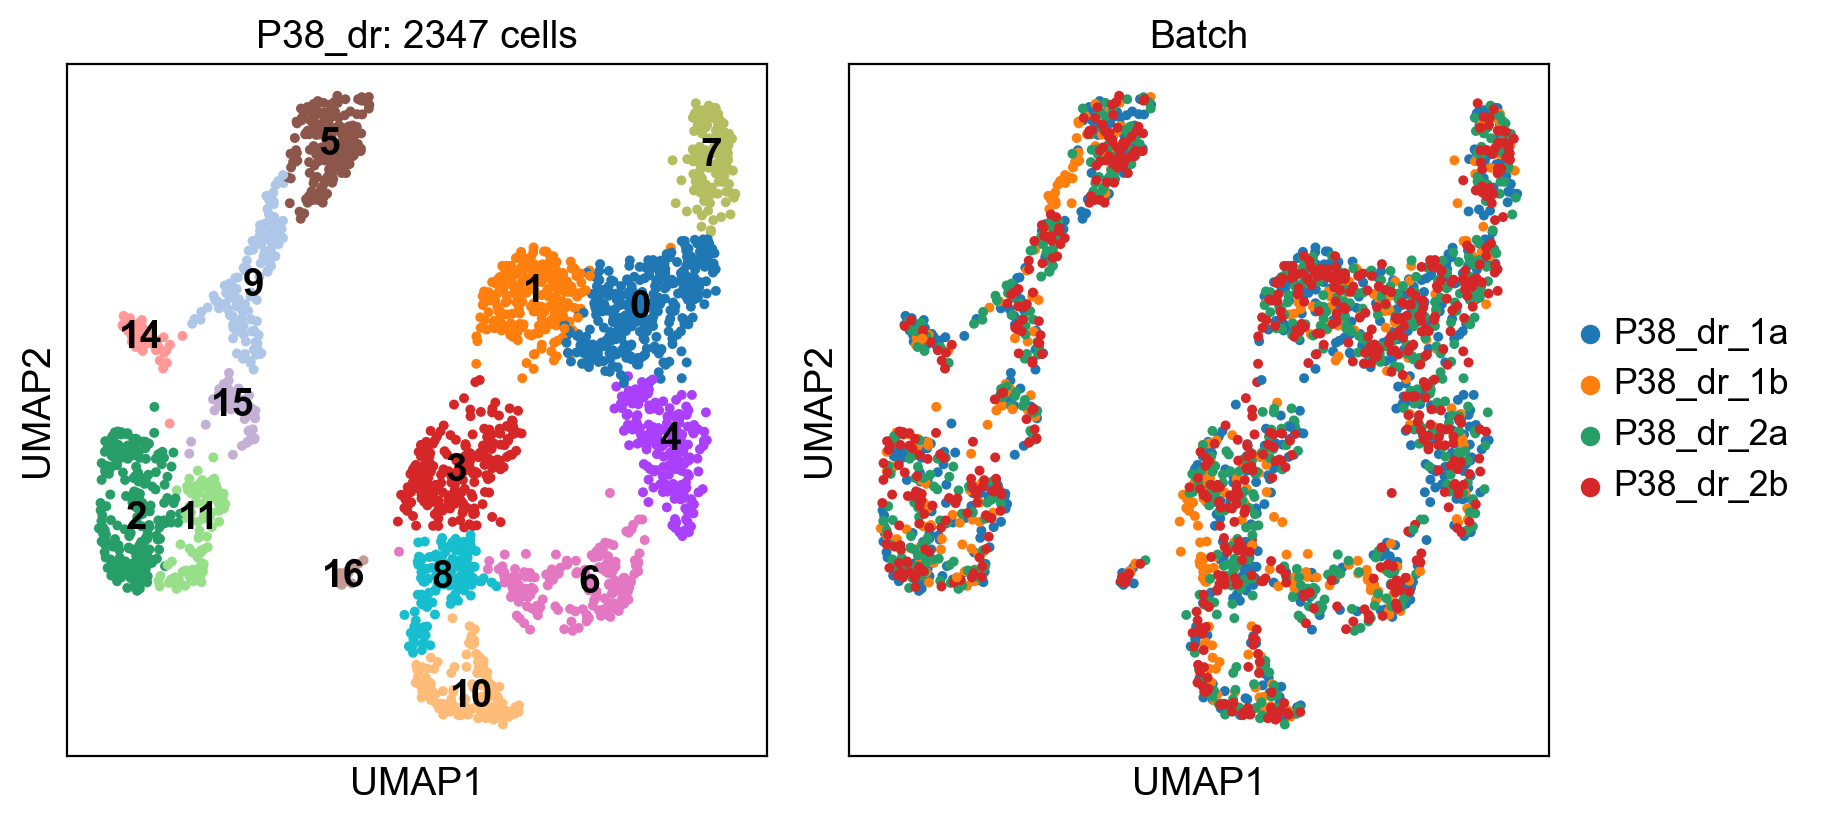

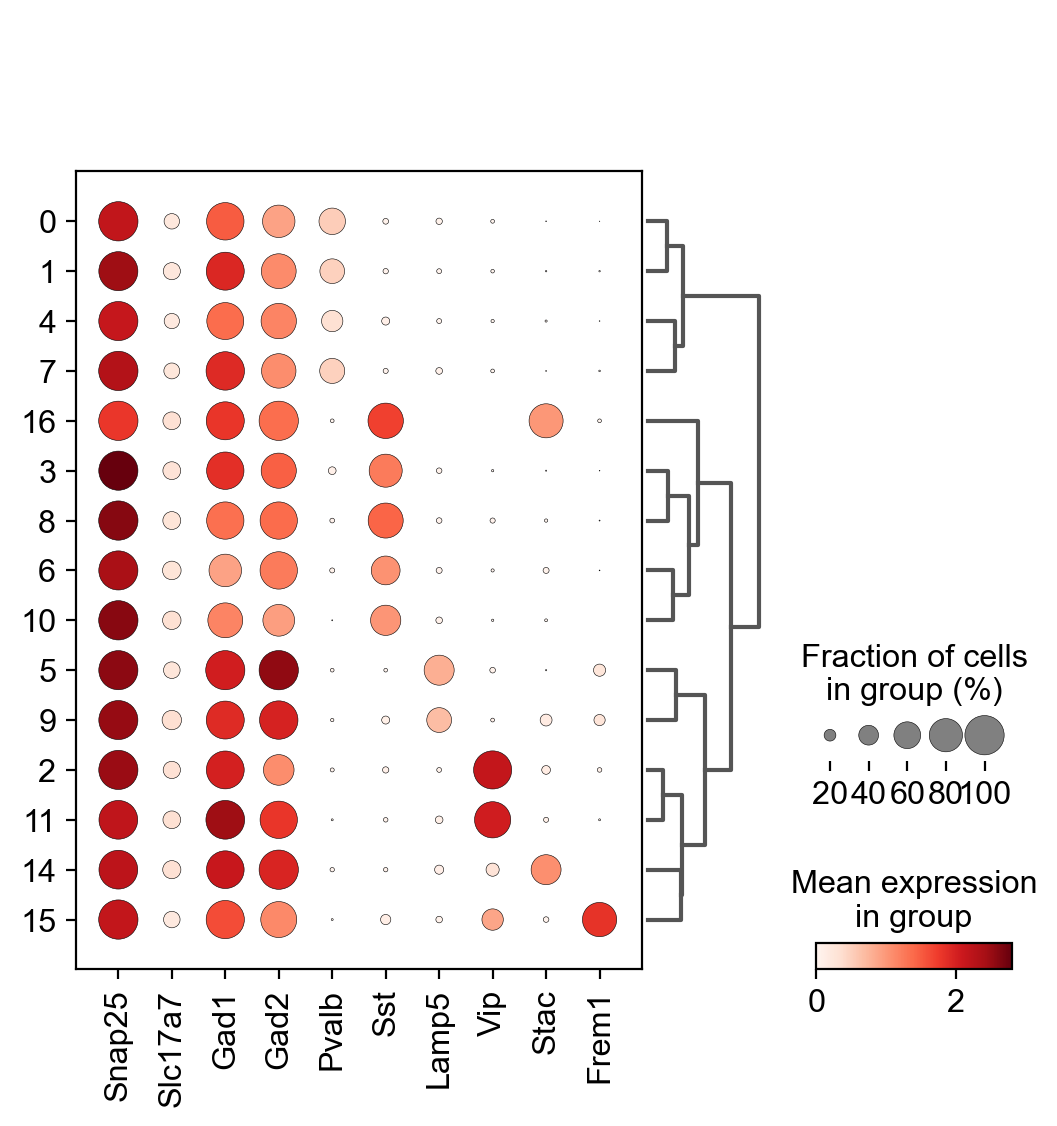

In [9]:
sc.tl.dendrogram(P38_gaba, groupby='leiden')
fig, axs = plt.subplots(1, 2, figsize = (9,4), constrained_layout=True)

'''
sc.pl.umap(P38_gaba, color='cluster', ax=axs[0], 
           show=False, legend_fontsize='10', legend_loc='on data',
           title='P38: ' + str(P38_gaba.shape[0]) + ' cells', 
          palette=('#17becf', '#8c564b', '#ffbb78', '#e377c2', '#ff7f0e', '#d62728', 
                  '#aec7e8', '#ff9896', '#98df8a', '#dbdb8d', '#f7b6d2', '#1f77b4', '#b5bd61', 
                  '#aa40fc', '#c5b0d5', '#c49c94'), frameon=True)
'''
sc.pl.umap(P38_gaba, color='leiden', ax=axs[0], show=False, 
           title='P38_dr: ' + str(P38_gaba.shape[0]) + ' cells', legend_loc='on data')
sc.pl.umap(P38_gaba, color='sample', ax=axs[1], show=False, title='Batch')

bias_markers = ['Snap25', 'Slc17a7', 'Gad1', 'Gad2', 'Pvalb', 'Sst', 'Lamp5', 'Vip', 'Stac', 'Frem1']

#bias_pos = [(0,6), (7,15)]
#bias_labels = ['Neuronal', 'Non-Neuronal']
sc.pl.dotplot(P38_gaba, bias_markers, groupby='leiden', dendrogram=True)

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


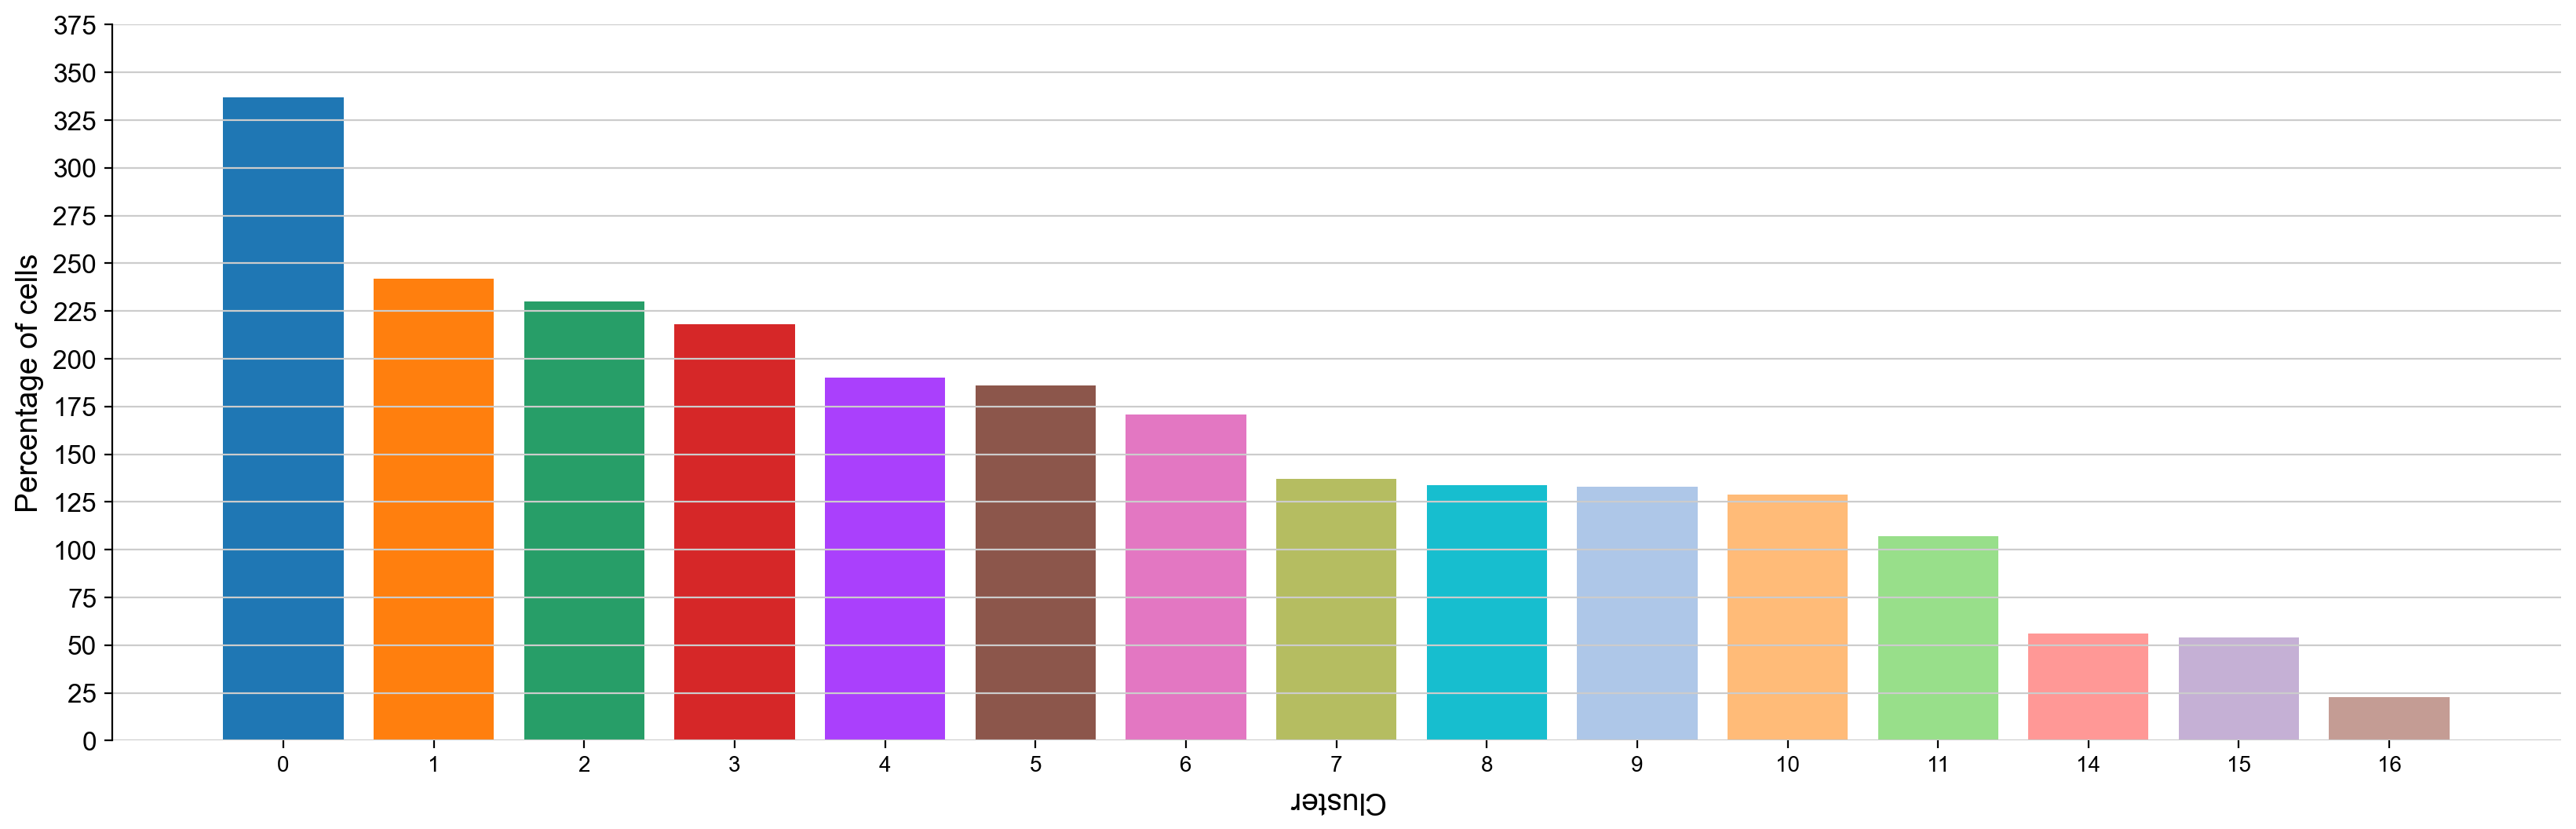

In [10]:
#code
x_pos = list(P38_gaba.obs.leiden.values.categories)

total_cells = P38_gaba.shape[0]
cell_fraction = []
cell_count = []

for i in x_pos:
    #cell_fraction.append(P38_gaba[P38_gaba.obs.leiden==i, :].shape[0]*100/total_cells)
    cell_fraction.append(P38_gaba[P38_gaba.obs.leiden==i, :].shape[0])
    cell_count.append(P38_gaba[P38_gaba.obs.leiden==i, :].shape[0])


fig, ax = plt.subplots(figsize=(20,6))

right_side = ax.spines["right"]
top = ax.spines["top"]
bottom = ax.spines["bottom"]

right_side.set_visible(False)
top.set_visible(False)
bottom.set_visible(False)


plt.bar(x_pos, cell_fraction, color = P38_gaba.uns['leiden_colors'])
plt.grid(axis='x')
plt.xticks(rotation='0', fontsize='10')
plt.yticks(fontsize ='12')

plt.xlabel('Cluster', rotation='180')
plt.ylabel('Percentage of cells')

plt.yticks(np.linspace(0, 375, 16))
plt.show()

In [12]:
P38_gaba.write_h5ad('P38_gaba_dr_Clustered.h5ad')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
